In [ ]:
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import joblib

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/all_mentioned_names.csv")

In [ ]:
df['full_name'] = df['full_name'].str.strip()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head()

,full_name,channel
0,Kathy Hochul,cnn
1,Don Clavin,cnn
2,Steve Bellone,cnn
3,Ian Levine,cnn
4,Melanie Zanona,cnn


In [ ]:
df.describe()

,full_name,channel
count,500616,500616
unique,333956,11
top,Bill,wapo
freq,20,95675


In [ ]:
vectorizer = joblib.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/pt_vec_fullname.joblib')


In [ ]:
max_name = 47
all_categories =  ['asian', 'hispanic', 'nh_black', 'nh_white', 'other']
n_categories = len(all_categories)

vocab = list(vectorizer.get_feature_names_out())
all_letters = ''.join(vocab)
n_letters = len(vocab)
oob = n_letters + 1
vocab_size = oob + 1

In [ ]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, df.columns.get_loc('full_name')]
    if self.transform:
      name_ids = self.transform(name)
    return name, name_ids

In [ ]:
def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    # if name is more than max_name
    try:
      if len(line) > max_name:
        line = line[:max_name]
      tensor = torch.ones(max_name) * oob
      for li, letter in enumerate(line):
          tensor[li] = letterToIndex(letter)
    except:
      print(line)
      raise
    return tensor

In [ ]:
dataset = EthniColorDataset(df, lineToTensor)

In [ ]:
for i in range(3):
  name, ids  = dataset[i]
  print(i, name, ids)

0 Kathy Hochul tensor([13., 29., 48., 36., 53.,  0., 10., 43., 31., 36., 49., 40., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
1 Don Clavin tensor([ 6., 43., 42.,  0.,  5., 40., 29., 50., 37., 42., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
2 Steve Bellone tensor([21., 48., 33., 50., 33.,  0.,  4., 33., 40., 40., 43., 42., 33., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])


In [ ]:
import os

batch_size=1024

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, len(sample_batched[0]), sample_batched[1].size())
    if i_batch == 2:
        break

0 1024 torch.Size([1024, 47])
1 1024 torch.Size([1024, 47])
2 1024 torch.Size([1024, 47])


In [ ]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = max_name

model = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/lstm_fullname.pt', map_location=device))
model.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # List to hold the predictions
    predictions = []
    names = []

    # Loop over the batches
    for batch in tqdm(dataloader):
        # Move the batch to the device the model is on
        nms = list(batch[0])
        tns = batch[1].to(device)
        # Compute the predictions
        outputs = model(tns)
        outputs = torch.argmax(outputs, dim=1)
        # Move the predictions to the CPU and convert to numpy arrays
        outputs = outputs.cpu().numpy()
        # Append the predictions to the list
        predictions.extend(list(outputs))
        names.extend(nms)

100%|██████████| 488/488 [00:14<00:00, 32.89it/s]


In [ ]:
results_df = pd.DataFrame({'names': names, 'predictions':predictions})

In [ ]:
results_df.head()

,names,predictions
0,David Kurtz,2
1,Jacob Strand,3
2,Melanie Ciccone,3
3,Ivana Dojkic,3
4,Philadelphian Staley,3


In [ ]:
results_df['preds'] = results_df['predictions'].apply(lambda x: all_categories[x])

In [ ]:
results_df.head()

,names,predictions,preds
0,David Kurtz,2,nh_black
1,Jacob Strand,3,nh_white
2,Melanie Ciccone,3,nh_white
3,Ivana Dojkic,3,nh_white
4,Philadelphian Staley,3,nh_white


In [ ]:
results_df.shape

(499712, 3)

In [ ]:
results_df['preds'].value_counts()

nh_white    245608
nh_black    147049
asian        66378
hispanic     34974
other         5703
Name: preds, dtype: int64

In [ ]:
res_dict = results_df['preds'].value_counts().to_dict()

<Axes: >

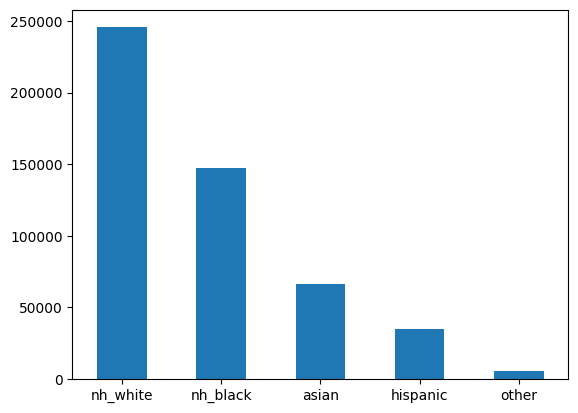

In [ ]:
results_df['preds'].value_counts().plot.bar(x='lab', y='val', rot=0)

In [ ]:
results_df.shape[0]

499712

In [ ]:
res_dict

{'nh_white': 245608,
 'nh_black': 147049,
 'asian': 66378,
 'hispanic': 34974,
 'other': 5703}

In [ ]:
for x in res_dict:
  print(f"{x} - {round(res_dict[x]/results_df.shape[0], 3)}%")

nh_white - 0.491%
nh_black - 0.294%
asian - 0.133%
hispanic - 0.07%
other - 0.011%


In [ ]:
df[df['full_name'] == 'Kathy Hochul']

,full_name,channel
0,Kathy Hochul,cnn
71896,Kathy Hochul,abc
81563,Kathy Hochul,cbs
130499,Kathy Hochul,nbc
172081,Kathy Hochul,npr
218942,Kathy Hochul,nyt
250574,Kathy Hochul,usat
313372,Kathy Hochul,wapo
409031,Kathy Hochul,politico
417443,Kathy Hochul,propub


In [ ]:
results_df[results_df['names'] == 'Kathy Hochul']

,names,predictions,preds
49713,Kathy Hochul,0,asian
57690,Kathy Hochul,0,asian
67878,Kathy Hochul,0,asian
88967,Kathy Hochul,0,asian
97200,Kathy Hochul,0,asian
105889,Kathy Hochul,0,asian
118533,Kathy Hochul,0,asian
134675,Kathy Hochul,0,asian
315829,Kathy Hochul,0,asian
374393,Kathy Hochul,0,asian


In [36]:
# prompt: merge df and results_df based on full_name and names

df1 = pd.merge(df, results_df.drop_duplicates(subset=['names'], keep='first'), left_on='full_name', right_on='names')
print(df1.head())

      full_name channel         names  predictions  preds
0  Kathy Hochul     cnn  Kathy Hochul            0  asian
1  Kathy Hochul     abc  Kathy Hochul            0  asian
2  Kathy Hochul     cbs  Kathy Hochul            0  asian
3  Kathy Hochul     nbc  Kathy Hochul            0  asian
4  Kathy Hochul     npr  Kathy Hochul            0  asian


In [37]:
df1[df1['full_name'] == 'Kathy Hochul']

,full_name,channel,names,predictions,preds
0,Kathy Hochul,cnn,Kathy Hochul,0,asian
1,Kathy Hochul,abc,Kathy Hochul,0,asian
2,Kathy Hochul,cbs,Kathy Hochul,0,asian
3,Kathy Hochul,nbc,Kathy Hochul,0,asian
4,Kathy Hochul,npr,Kathy Hochul,0,asian
5,Kathy Hochul,nyt,Kathy Hochul,0,asian
6,Kathy Hochul,usat,Kathy Hochul,0,asian
7,Kathy Hochul,wapo,Kathy Hochul,0,asian
8,Kathy Hochul,politico,Kathy Hochul,0,asian
9,Kathy Hochul,propub,Kathy Hochul,0,asian


In [38]:
df1 = df1[['full_name', 'channel', 'preds', 'predictions']]

In [39]:
df1.groupby(['channel', 'preds']).size()

channel   preds   
abc       asian        1962
          hispanic     1247
          nh_black     4647
          nh_white     7817
          other         214
cbs       asian        6040
          hispanic     3245
          nh_black    15191
          nh_white    24059
          other         619
cnn       asian        8733
          hispanic     4233
          nh_black    18647
          nh_white    32800
          other         860
lat       asian       10442
          hispanic     7363
          nh_black    23458
          nh_white    38780
          other         702
nbc       asian        5144
          hispanic     3121
          nh_black    11701
          nh_white    19848
          other         461
npr       asian        8225
          hispanic     3392
          nh_black    13654
          nh_white    22209
          other         624
nyt       asian        4363
          hispanic     2202
          nh_black     8740
          nh_white    15557
          other         388
p

<Axes: xlabel='channel'>

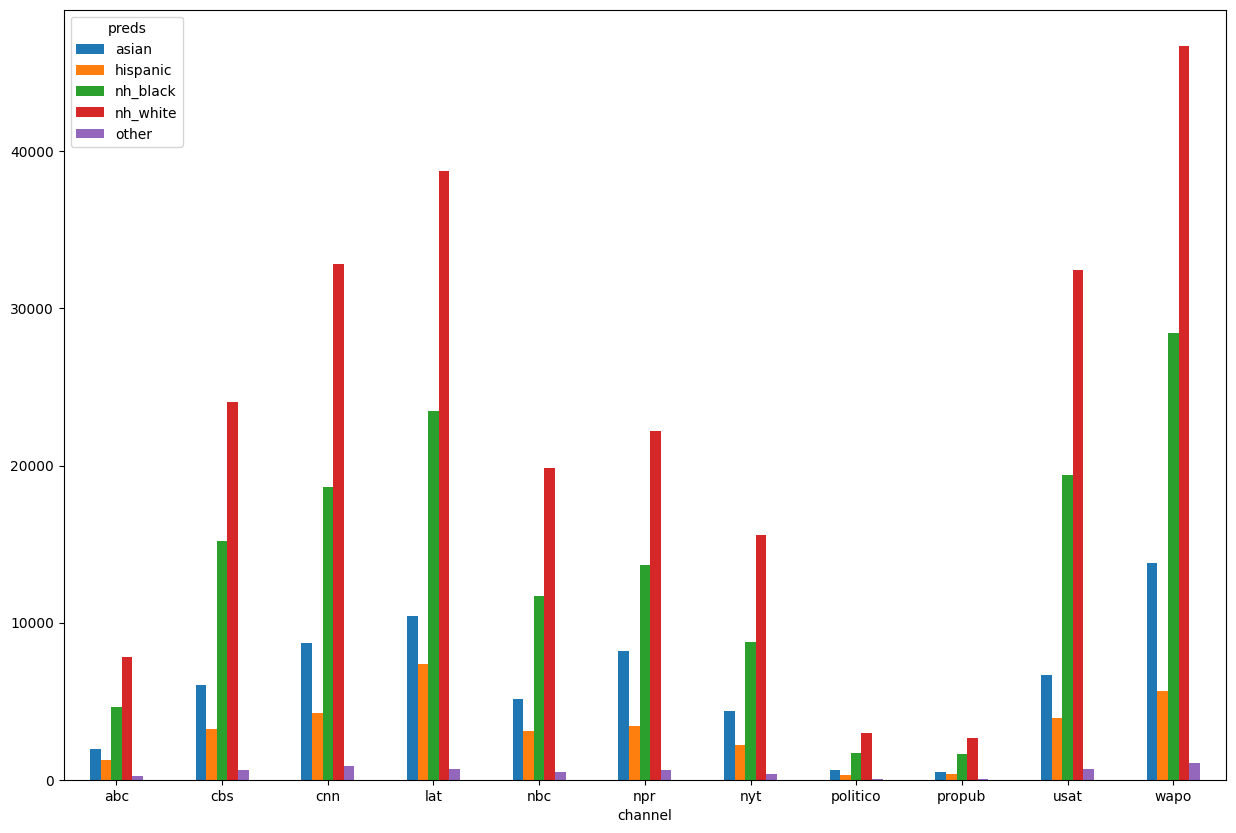

In [40]:
df1.groupby(['channel', 'preds']).size().unstack(fill_value=0).plot(kind='bar', figsize=(15, 10), rot=0)


In [41]:
def plot_by(channel):
  df1[df1['channel'] == channel].groupby(['channel', 'preds']).size().unstack(fill_value=0).plot(kind='bar', figsize=(10, 5), rot=0)


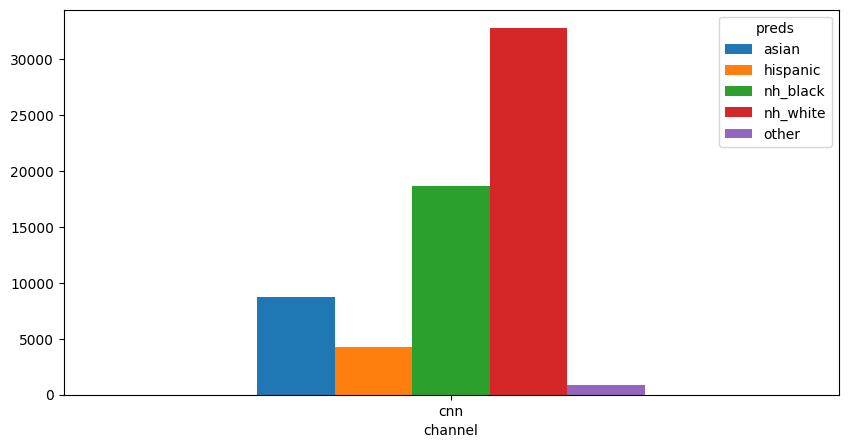

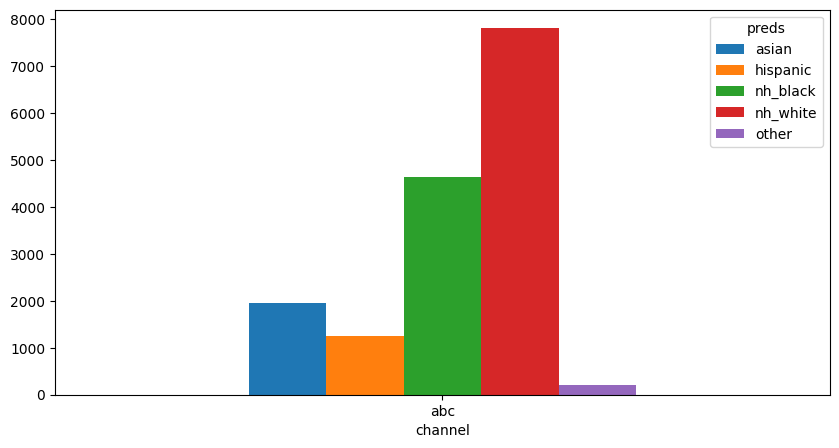

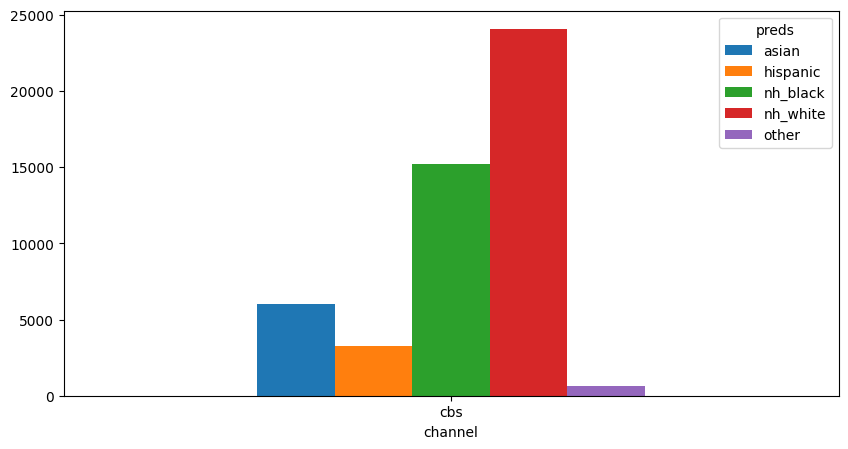

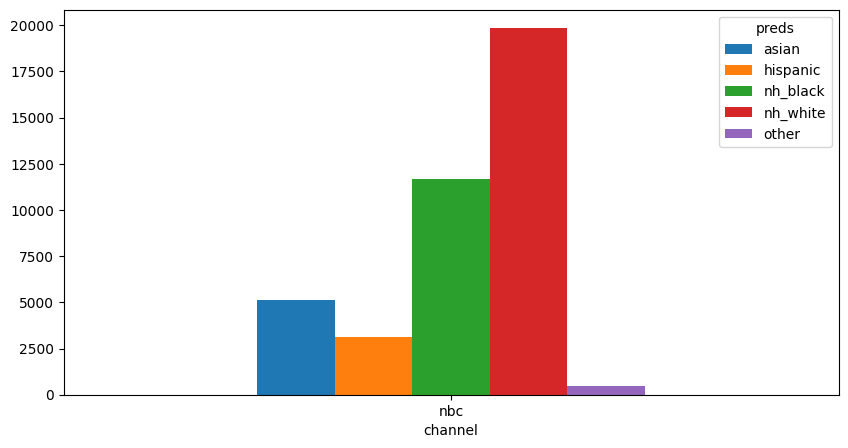

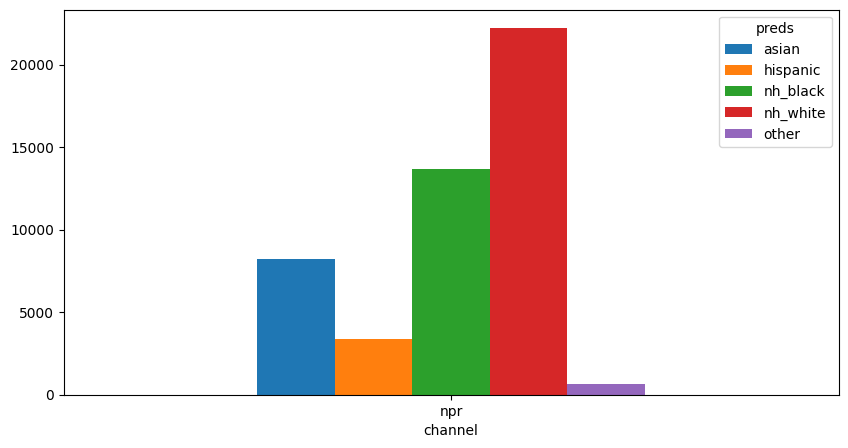

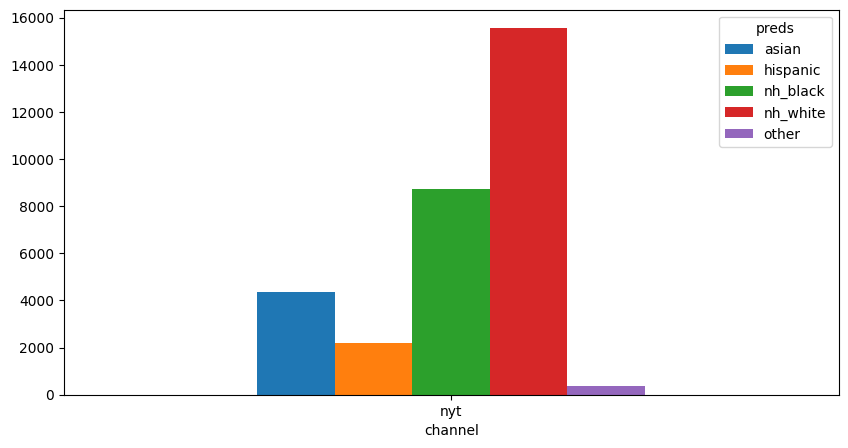

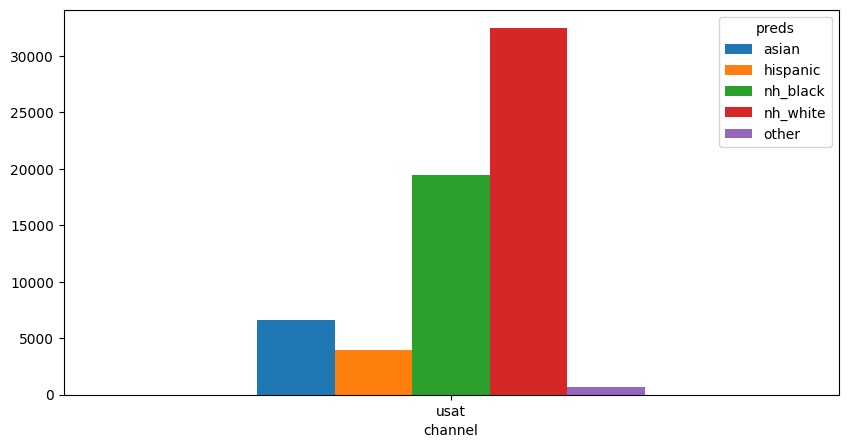

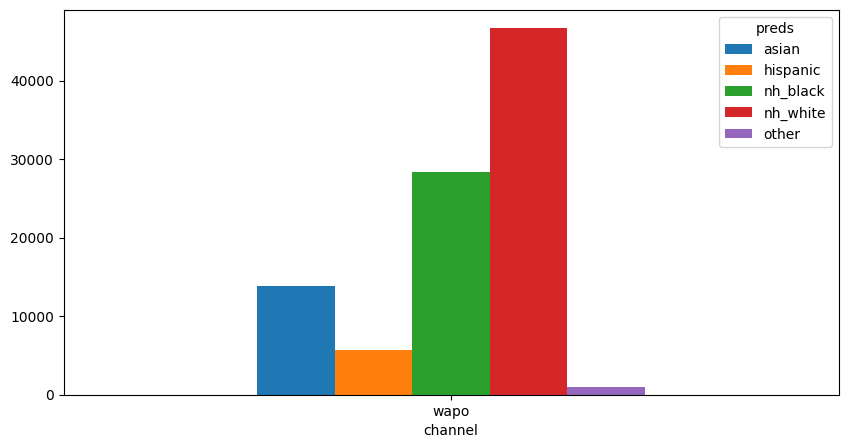

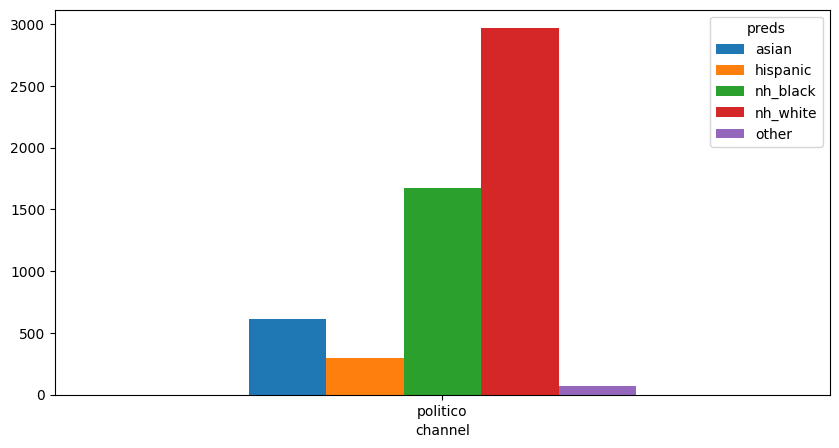

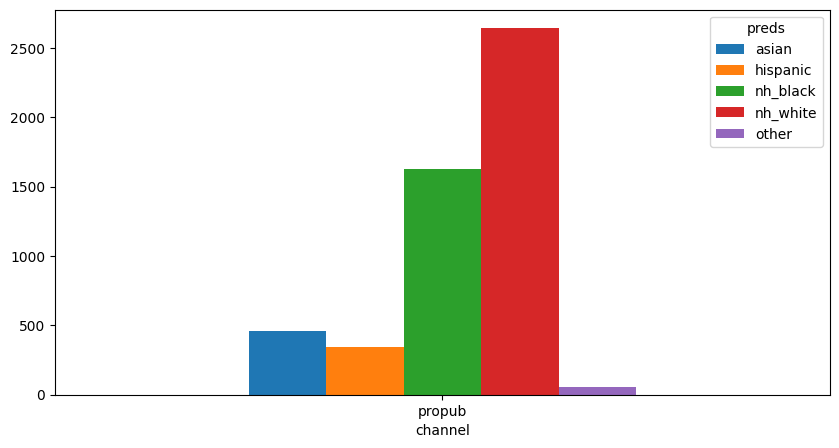

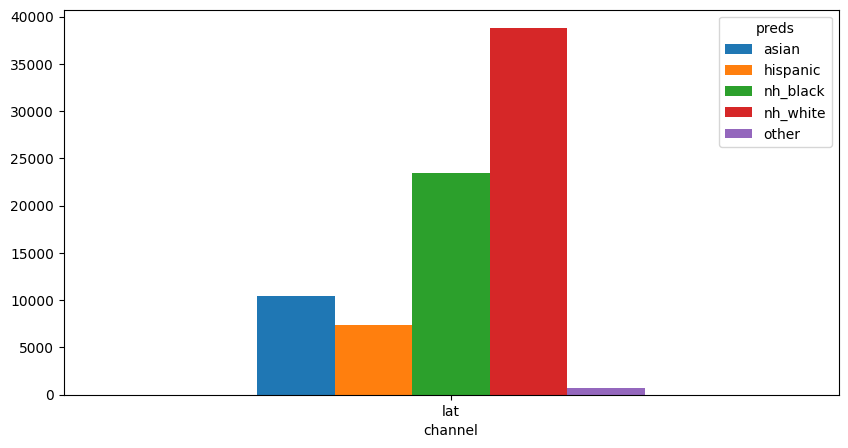

In [42]:
for channel in df1['channel'].unique():
  plot_by(channel)

In [43]:
df1.to_csv("/content/drive/MyDrive/Colab/ethnicolor/data/news_mentioned_names_results.csv", index=False)

In [44]:
ch_pr = df1.groupby(['channel', 'preds']).size().to_dict()

news = {}
totals = {}
for x in ch_pr:
  channel = x[0]
  preds = x[1]
  if channel not in news:
    news[channel] = {}
    totals[channel] = ch_pr[x]
  news[channel][preds] = ch_pr[x]
  totals[channel] += ch_pr[x]

In [45]:
for channel in news:
  print(channel)
  for race in news[channel]:
    print(f"{race} - {round(news[channel][race]/totals[channel], 3)}%")
  print()

abc
asian - 0.11%
hispanic - 0.07%
nh_black - 0.26%
nh_white - 0.438%
other - 0.012%

cbs
asian - 0.109%
hispanic - 0.059%
nh_black - 0.275%
nh_white - 0.436%
other - 0.011%

cnn
asian - 0.118%
hispanic - 0.057%
nh_black - 0.252%
nh_white - 0.443%
other - 0.012%

lat
asian - 0.115%
hispanic - 0.081%
nh_black - 0.257%
nh_white - 0.425%
other - 0.008%

nbc
asian - 0.113%
hispanic - 0.069%
nh_black - 0.258%
nh_white - 0.437%
other - 0.01%

npr
asian - 0.146%
hispanic - 0.06%
nh_black - 0.242%
nh_white - 0.394%
other - 0.011%

nyt
asian - 0.123%
hispanic - 0.062%
nh_black - 0.245%
nh_white - 0.437%
other - 0.011%

politico
asian - 0.098%
hispanic - 0.048%
nh_black - 0.269%
nh_white - 0.476%
other - 0.012%

propub
asian - 0.082%
hispanic - 0.062%
nh_black - 0.291%
nh_white - 0.473%
other - 0.01%

usat
asian - 0.095%
hispanic - 0.056%
nh_black - 0.278%
nh_white - 0.465%
other - 0.01%

wapo
asian - 0.126%
hispanic - 0.052%
nh_black - 0.26%
nh_white - 0.427%
other - 0.01%

